# The bead-spring model with $N=2$

In this notebook, we introduce the way how to use the CNEEP for estimating the EP or for quantifying the dissipation map from the movies.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys, os
sys.path.append('drive/MyDrive/CNEEP/')

In [3]:
from argparse import Namespace

import numpy as np
from scipy import stats
import torch
import torch.nn as nn

from drive.MyDrive.CNEEP.misc.sampler import CartesianSampler, CartesianSeqSampler
from drive.MyDrive.CNEEP.toy.bead_spring import del_medium_etpy, del_shannon_etpy, simulation, p_ss

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from IPython.display import display, clear_output, HTML, Image
from matplotlib import animation, rc
Writer = animation.writers['pillow']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

%config InlineBackend.figure_format = 'retina'
mpl.rcParams['mathtext.fontset']='cm'
mpl.rcParams['mathtext.rm'] = 'serif'
mpl.rcParams['text.usetex'] = False
# csfont = {'fontname':'Times New Roman'}
plt.rcParams['font.family'] = 'sans-serif'



## CNEEP Architecture

In [4]:
from torchvision import transforms
flag = 0
latent_size = 8

class CNEEP(nn.Module):
    def __init__(self, opt):
        super(CNEEP, self).__init__()
        self.n_layer = opt.n_layer
        self.init_channel = opt.n_channel

        #
        # conv layers
        #
        tmp = nn.Sequential()
        tmp.add_module("conv", nn.Conv2d(opt.seq_len, opt.n_channel, kernel_size=5, stride=1, padding=2))
        tmp.add_module("relu", nn.ReLU(inplace=True))
        tmp.add_module("maxpool", nn.MaxPool2d(kernel_size=2 , stride=2))
        setattr(self, "layer1", tmp)
        for i in range(opt.n_layer-1):
            tmp = nn.Sequential()
            tmp.add_module("conv1", nn.Conv2d(opt.n_channel * (2**i), opt.n_channel * (2**i), kernel_size=3, stride=1, padding=1))

            tmp.add_module("relu1", nn.ReLU(inplace=True))
            tmp.add_module("conv2", nn.Conv2d(opt.n_channel * (2**i), opt.n_channel * (2**(i+1)), kernel_size=3, stride=1, padding=1))

            tmp.add_module("relu2", nn.ReLU(inplace=True))

            if i < opt.n_layer-2:
                tmp.add_module("maxpool", nn.MaxPool2d(kernel_size=2, stride=2))

            setattr(self, "layer%d" % (i + 2), tmp)

        id = nn.Sequential()
        id.add_module("id", nn.Identity())
        setattr(self, "id", id)

        id2 = nn.Sequential()
        id2.add_module("id2", nn.Identity())
        setattr(self, "id2", id2)

        #
        # fc layers (fully connected capacity)
        #
        tempH, tempW = opt.input_shape
        input_size = opt.n_channel * (2**(opt.n_layer+1)) * ((tempH+1)//(2**(2 + opt.n_layer-2))) * ((tempW+1)//(2**(2 + opt.n_layer-2)))
        self.fc1 = nn.Linear(input_size, latent_size, bias=True)
        self.fc2 = nn.Linear(latent_size, input_size, bias=True)
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)

        self.lat1 = nn.Sequential(
            self.fc1
        )

        self.lat2 = nn.Sequential(
            self.fc2
        )


        #
        # upsample layers
        #
        for i in list(reversed(range(opt.n_layer-1))):
            tmp = nn.Sequential()

            if i < opt.n_layer-2:
                tmp.add_module("upsample", nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True))

            tmp.add_module("conv1", nn.Conv2d(opt.n_channel * (2**(i+1)), opt.n_channel * (2**i), kernel_size=3, stride=1, padding=1))

            tmp.add_module("relu1", nn.ReLU(inplace=True))
            tmp.add_module("conv2", nn.Conv2d(opt.n_channel * (2**i), opt.n_channel * (2**i), kernel_size=3, stride=1, padding=1))

            tmp.add_module("relu2", nn.ReLU(inplace=True))

            setattr(self, "r_layer%d" % (i + 2), tmp)

        tmp = nn.Sequential()
        tmp.add_module("upsample", nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True))
        tmp.add_module("conv", nn.Conv2d(opt.n_channel, 1, kernel_size=5, stride=1, padding=2))
        setattr(self, "r_layer1", tmp)


        # initialize parameters
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x_ = x
        _x = torch.flip(x, [1])

        #
        # foward path
        #
        for i in range(self.n_layer):
            f = getattr(self, "layer%d" % (i + 1))
            x_ = f(x_)

        batch, channel, height, width = x_.shape
        x_ = x_.view(batch, -1)
        x_ = self.lat1(x_)
        x_ = getattr(self, "id2")(x_)
        x_ = self.lat2(x_)
        x_ = x_.view(batch, channel, height, width)

        for i in list(reversed(range(self.n_layer))):
            f = getattr(self, "r_layer%d" % (i+1))
            x_ = f(x_)

        x_ = getattr(self, "id")(x_)

        #
        # backward path
        #
        for i in range(self.n_layer):
            f = getattr(self, "layer%d" % (i + 1))
            _x = f(_x)

        batch, channel, height, width = _x.shape
        _x = _x.view(batch, -1)
        _x = self.lat1(_x)
        _x = getattr(self, "id2")(_x)
        _x = self.lat2(_x)
        _x = _x.view(batch, channel, height, width)

        for i in list(reversed(range(self.n_layer))):
            f = getattr(self, "r_layer%d" % (i+1))
            _x = f(_x)

        _x = getattr(self, "id")(_x)

        #
        # anti-symmetric output
        #

        return (x_ - _x)


## Training Algorithm

In [53]:
alpha = -0.5
from torchvision import transforms

def train(opt, model, optim, trajs, sampler, transform):
    model.train()
    batch = next(sampler)

    x = transform(torch.cat([trajs.to(opt.device)[(batch[0], batch[1][i])] for i in range(opt.seq_len)], dim=1).float().to(opt.device))
    x[:, :, :, 20:40] = 0
    delta = x[:, 0, :, :] - x[:, 1, :, :]
    delta = delta.reshape(x.shape[0], 1, x.shape[2], x.shape[3])

    mapp = model(x)
    #delta = transforms.Resize((mapp.shape[2], mapp.shape[3]))(torch.abs(delta))

    ent_production = torch.mean(mapp.reshape(x.shape[0], -1), dim = 1)

    mu = 0
    lam = 20
    rho_1 = 0.3
    rho_2 = 0.3
    # eps = 1e-6
    #cos = nn.functional.cosine_similarity(delta.reshape(x.shape[0], -1), mapp.reshape(x.shape[0], -1))
    #R = 0 * (mu * torch.log(1 + torch.exp(-lam * torch.abs(cos)))).mean()
    # R = (mu * torch.log(1 + torch.exp( - lam * torch.abs(mapp) / (delta + eps)))).mean()
    #mapp = (mapp - torch.mean(mapp, dim = 1)) / torch.std(mapp, dim = 1)

    _std = torch.std(mapp)
    R = mu * torch.mean(1/(1 + torch.exp(-lam * (torch.abs((mapp) / _std) - rho_1))) * (1 - 1 / (1 + torch.exp(-lam * (torch.abs(delta) - rho_2)))))
    #R = mu * torch.mean(torch.abs(mapp) * (1 - 1 / (1 + torch.exp(-lam * (torch.abs(delta) - rho_2)))))
    #R = mu * torch.mean(torch.abs(mapp) * (1 - torch.heaviside(torch.abs(delta) - rho_2, torch.abs(delta) - rho_2)))
    R = torch.zeros(1).to(opt.device)

    optim.zero_grad()

    # The objective function J. Equation (2)
    #loss = (-ent_production + torch.exp(-ent_production)).mean()
    loss = (- (torch.exp(alpha * ent_production) - 1) / alpha + (torch.exp(-(1 + alpha) * ent_production) - 1) / (1 + alpha)).mean()
    (loss + R).backward()
    optim.step()
    return loss.item(), R.item()


def validate(opt, model, trajs, sampler, transform):
    model.eval()

    ret = []
    loss = 0
    with torch.no_grad():
        for batch in sampler:
            x = transform(torch.cat([trajs.to(opt.device)[(batch[0], batch[1][i])] for i in range(opt.seq_len)], dim=1).float().to(opt.device))

            ent_production = torch.mean(model(x).view(x.shape[0], -1), dim = 1)
            entropy = ent_production.cpu().squeeze().numpy()
            ret.append(entropy)
            #loss = (ent_production - torch.exp(-ent_production)).sum().cpu().item()
            loss += (- (torch.exp(alpha * ent_production) - 1) / alpha + (torch.exp(-(1 + alpha) * ent_production) - 1) / (1 + alpha)).sum().cpu().item()
    loss = loss / sampler.size
    ret = np.concatenate(ret)
    ret = ret.reshape(trajs.shape[0], -1)
    return ret, loss



## Hyper-parameters

In [6]:
opt = Namespace()
opt.device = "cuda"
opt.batch_size = 4000
opt.test_batch_size = 10000
opt.video_batch_size = 400
opt.n_hidden = 512

opt.lr = 1e-3
opt.wd = 1e-5

opt.record_freq = 1000
opt.seed = 3       # In our paper, we used the seed numbers from 1 to 5 for five independent estimators.

opt.n_layer = 2
opt.n_channel = 32

opt.input_shape = (20, 40)     # the shape of images
opt.M = 10         # number of trajectories
opt.L = 1000        # lenth of a trjectory
opt.seq_len = 2      # length of consecutive transitions for inputs (see the section 'incomplete scenarios')
opt.Tc = 1            # cold temperature
opt.Th = 10           # hot temperature
opt.time_step = 0.01  # time step size for Langevin simulation

torch.manual_seed(opt.seed)

## Load bead-spring movies with $N=2$

In [7]:
train_imgs = np.load("drive/MyDrive/CNEEP/data/beads_2/train/img_2beads_1.0_(%d, %d).npy" %(opt.Tc, opt.Th))
test_imgs = np.load("drive/MyDrive/CNEEP/data/beads_2/test/img_2beads_1.0_(%d, %d).npy" %(opt.Tc, opt.Th))

trajs_np = np.load("drive/MyDrive/CNEEP/data/beads_2/train/trj_2beads_0_(%d, %d).npy" %(opt.Tc, opt.Th))
test_trajs_np = np.load("drive/MyDrive/CNEEP/data/beads_2/test/trj_2beads_0_(%d, %d).npy" %(opt.Tc, opt.Th))



In [ ]:
train_imgs.shape, test_imgs.shape

((100, 10000, 20, 40), (100, 10000, 20, 40))

In [8]:

train_imgs_t = torch.from_numpy(train_imgs[:opt.M, :opt.L]).float().reshape((opt.M, opt.L, 1, 20, 40))
trajs_t = torch.from_numpy(trajs_np[:opt.M, :opt.L]).float()

# Here, a test dataset is used to check how well the estimator trains
test_imgs_t = torch.from_numpy(test_imgs[:opt.M, :opt.L]).float().reshape((opt.M, opt.L, 1, 20, 40))
test_trajs_t = torch.from_numpy(test_trajs_np[:opt.M, :opt.L]).float()

print("A shape of train_imgs_t (test_imgs_t) (opt.M, opt.L, 1 (channel), width, height): ", train_imgs_t.shape)
print("A shape of trajs_t (test_trajs_t) (opt.M, opt.L, # of beads): ", test_trajs_t.shape)

A shape of train_imgs_t (test_imgs_t) (opt.M, opt.L, 1 (channel), width, height):  torch.Size([10, 1000, 1, 20, 40])
A shape of trajs_t (test_trajs_t) (opt.M, opt.L, # of beads):  torch.Size([10, 1000, 2])


(0.0, 1.1)

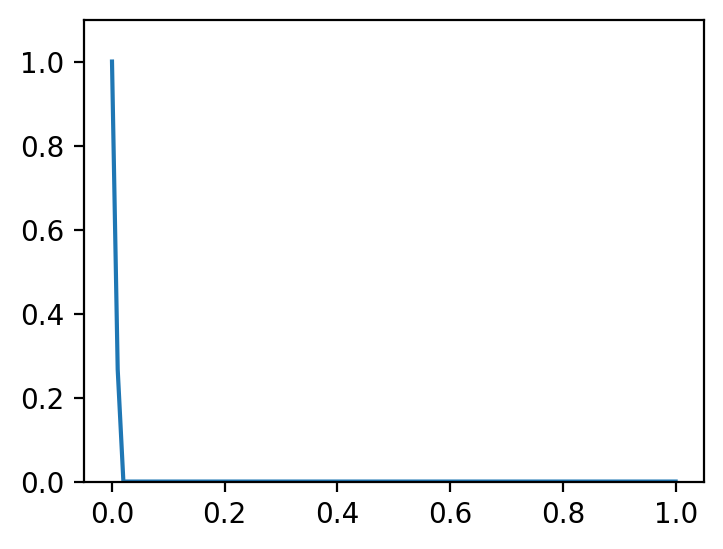

In [ ]:
fig, ax = plt.subplots(figsize=(4, 3), dpi=100)

def sigmoid(z, th, lam=10):
    return 1/(1 + np.exp(-lam * (np.abs(z)-th)))

x_axis = np.linspace(0, 1, 100)
y_axis = 1 - sigmoid(x_axis, 0.01, lam=10000)

plt.plot(x_axis, y_axis)
ax.set_ylim(0, 1.1)

(0.0, 1.1)

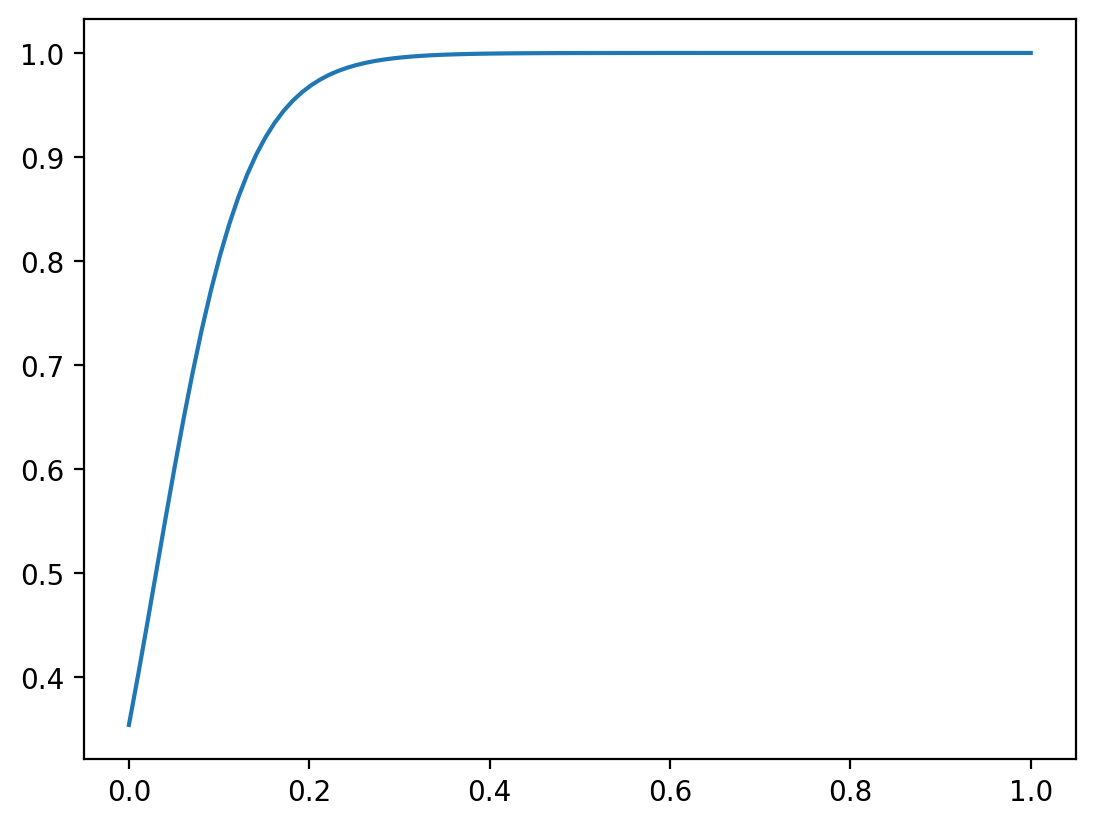

In [ ]:
x_axis = np.linspace(0, 1, 100)
y_axis = sigmoid(x_axis, 0.03, lam=20)

plt.plot(x_axis, y_axis)
ax.set_ylim(0, 1.1)

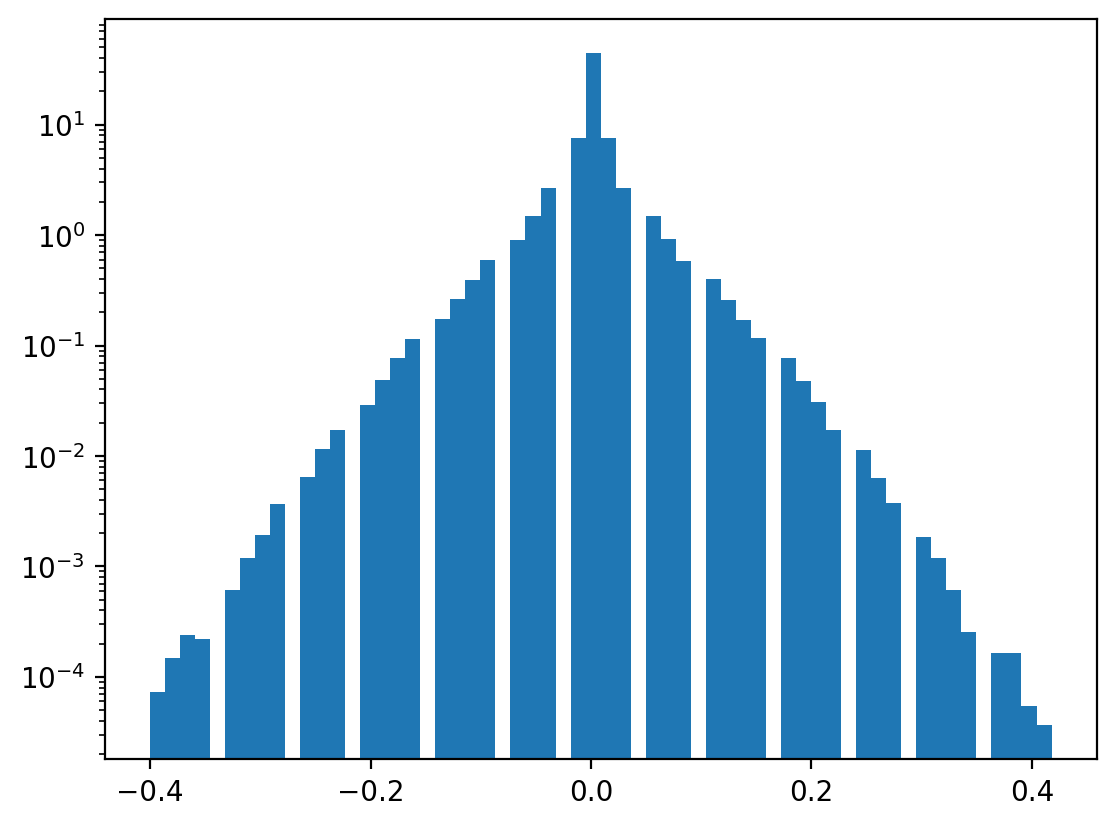

In [ ]:
temp_imgs_t = (train_imgs_t[:,:,:,:, :20] - train_imgs_t[:,:,:,:, :20].mean())/train_imgs_t[:,:,:,:, :20].std()

temp_diff_t = temp_imgs_t.diff(axis=1)
temp_diff_t = temp_diff_t.flatten()

plt.hist(temp_diff_t, bins=60, density=True)
# plt.xscale('log')
plt.yscale('log')

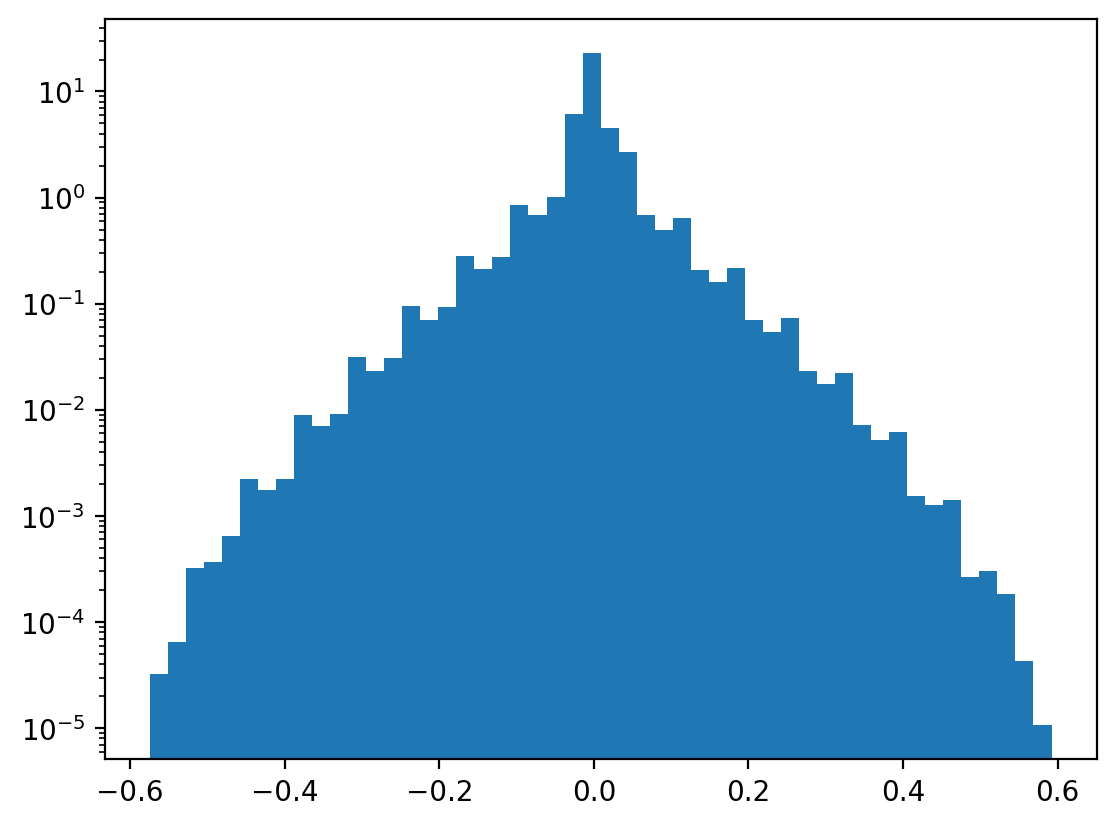

In [ ]:
temp_imgs_t = (train_imgs_t[:,:,:,:, 20:40] - train_imgs_t[:,:,:,:, 20:40].mean())/train_imgs_t[:,:,:,:, 20:40].std()

temp_diff_t = temp_imgs_t.diff(axis=1)
temp_diff_t = temp_diff_t.flatten()

plt.hist(temp_diff_t, bins=50, density=True)
# plt.xscale('log')
plt.yscale('log')

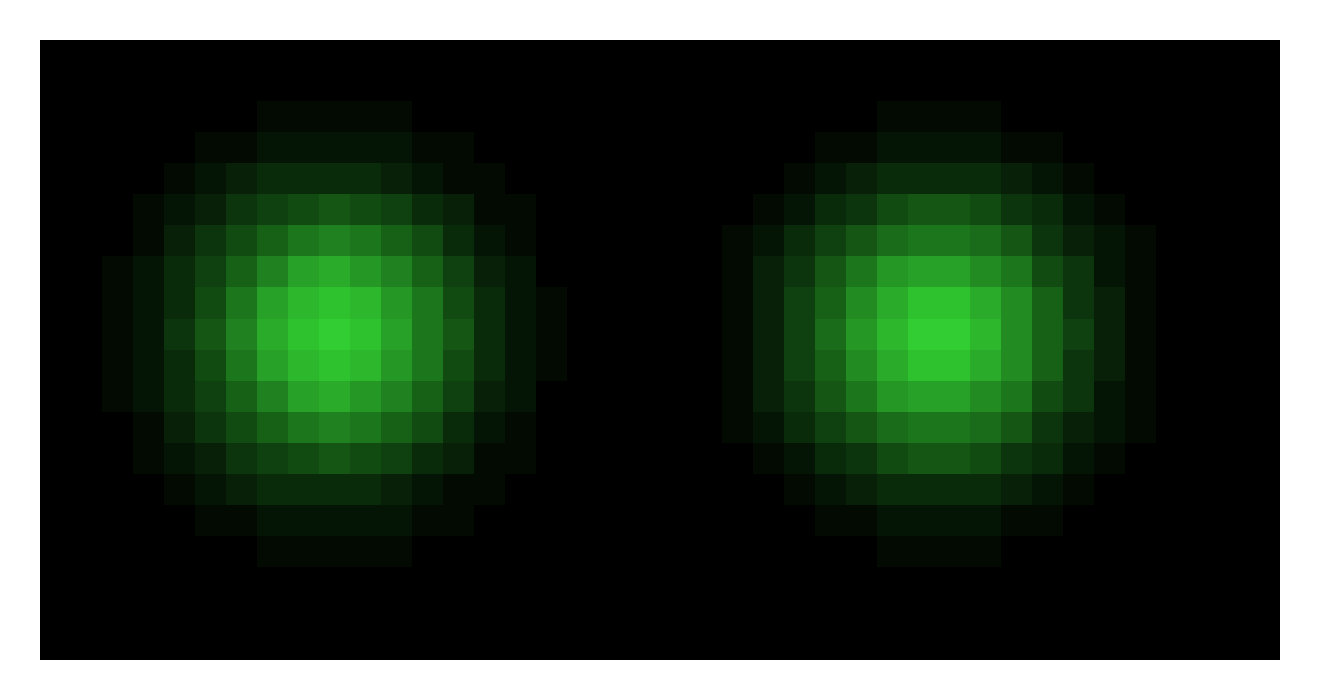

In [12]:
fig1, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(4, 3), dpi=200)
plt.axis('off')

frame_length = 1000

img = ax1.imshow(train_imgs[0][0].astype(np.float32)/255, cmap= mpl.colors.LinearSegmentedColormap.from_list('my_colormap',
                                                    ['black','limegreen'], 20),
                   vmin=0, vmax=1, extent=[0, 2, 0, 1], origin ='lower')



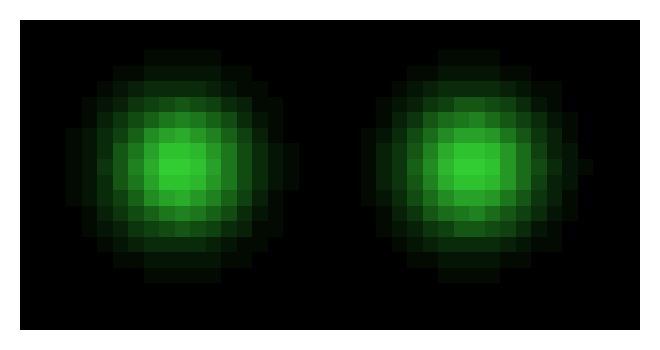

In [11]:
def update_graph(i):
    draw_frame.set_data(frames[:i])

def animate(i):
    img.set_data(train_imgs[0][i].astype(np.float32)/255)
    return (img,)

fig1, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(4, 3), dpi=100)
plt.axis('off')

frame_length = 1000

img = ax1.imshow(train_imgs[0][0].astype(np.float32)/255, cmap= mpl.colors.LinearSegmentedColormap.from_list('my_colormap',
                                                    ['black','limegreen'], 20),
                   vmin=0, vmax=1, extent=[0, 2, 0, 1], origin ='lower')

anim = animation.FuncAnimation(fig1, animate, frames=frame_length, interval=50, blit=True)
HTML(anim.to_html5_video())


## Let's build our model!

In [54]:
# The pixel values in the loaded images range from 0 to 255 integers, so we rescale them from -1 to 1 for training.
mean, std = train_imgs[0][0].mean(), train_imgs[0][0].std()
transform = lambda x: (x - mean)/std

# Build the model
model = CNEEP(opt)
model = model.to(opt.device)
optim = torch.optim.Adam(model.parameters(), opt.lr, weight_decay=opt.wd)

train_sampler = CartesianSeqSampler(opt.M, opt.L, opt.seq_len, opt.batch_size, device=opt.device)
test_sampler = CartesianSeqSampler(opt.M, opt.L, opt.seq_len, opt.test_batch_size, device=opt.device, train=False)


In [10]:
# A function for a scatter plot between true EPs and estimations.
def plot_scatter(pred, ent, save_path=None, trained=False):
    pred_rate, _, r_value, pvalue, _  = stats.linregress(ent, pred)
    plt.figure(figsize=(3,3), dpi=100)
    sns.regplot(x = ent, y = pred,
                color='C3',
                line_kws={
                    'lw':2.0,
                    'label':'$R^2=$ %.4f' %(r_value**2)},
                scatter_kws={
                    'color':'grey',
                    'alpha':0.03,
                    's':3,
                    'rasterized':True},
                )
    plt.ylim(-2, 2)
    plt.xlim(-2, 2)
    plt.xlabel('$\Delta S$', fontsize=25)
    plt.ylabel('$\Delta S_{\\theta}$', fontsize=25)
    plt.xticks([-2, 0, 2], fontsize=20)
    if trained:
        plt.yticks([-2, 0, 2], fontsize=20)
    else:
        plt.yticks([-0.05, 0, 0.05], fontsize=20)
    plt.legend(loc="upper center", fontsize=15, frameon = False)

    if save_path is not None:
        plt.savefig(save_path)

<>:18: SyntaxWarning: invalid escape sequence '\D'
<>:19: SyntaxWarning: invalid escape sequence '\D'
<>:18: SyntaxWarning: invalid escape sequence '\D'
<>:19: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipython-input-4193017389.py:18: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel('$\Delta S$', fontsize=25)
/tmp/ipython-input-4193017389.py:19: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('$\Delta S_{\\theta}$', fontsize=25)


In [13]:
#preds_untrained, _ = validate(opt, model, train_imgs_t, test_sampler, transform)

# Analytic EP
ents = del_medium_etpy(trajs_t, 1, 10) + del_shannon_etpy(trajs_t, 1, 10)

In [ ]:
# A scatter plot before training the CNEEP

plot_scatter(preds_untrained.flatten(), ents.numpy().flatten())

NameError: name 'preds_untrained' is not defined

## Training process

This is the process for training the estimator (the detailed algorithm is written in Supplemental material).
For the convenience, we just use the estimator's parameter $\theta$ obtained at the end of training.
Of course, for the best performance, it would be better to use the $\theta$ at the optimal loss by checking the loss values w.r.t. training iterations as written in Supplementary Material; please check 'BeadSpring.py' for the python code.


In [56]:
opt.n_iter = 200    # number of training iteration

train_losses = []
R_losses = []
valid_losses = []

from datetime import datetime
best_valid_loss = float('inf') # Initialize with a very large value
best_name = f"drive/MyDrive/CNEEP/results/2BS/T_1/L_10000/{datetime.today().strftime('%Y%m%d%H%M%S')}_(0.1, 10)_wo_st.pth.tar"

for i in tqdm(range(1, opt.n_iter + 1)):
    train_loss, R_loss = train(opt, model, optim, train_imgs_t, train_sampler, transform)
    train_losses.append(train_loss)
    R_losses.append(R_loss)

    _, valid_loss = validate(opt, model, test_imgs_t, test_sampler, transform)
    valid_losses.append(valid_loss)

    # Save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        state = {
            'state_dict': model.state_dict(),
            'optimizer': optim.state_dict(),
            'epoch': i,
            'best_valid_loss': best_valid_loss
        }
        torch.save(state, best_name)


  0%|          | 0/200 [00:00<?, ?it/s]

In [43]:

model.load_state_dict(torch.load(best_name,weights_only=False)['state_dict'])

<All keys matched successfully>

In [45]:
model.load_state_dict(torch.load("drive/MyDrive/CNEEP/results/2BS/T_1/L_10000/20251229144116_(0.1, 10).pth.tar",weights_only=False)['state_dict'])

FileNotFoundError: [Errno 2] No such file or directory: 'drive/MyDrive/CNEEP/results/2BS/T_1/L_10000/20251229144116_(0.1, 10).pth.tar'

-3.8514375773957e-05


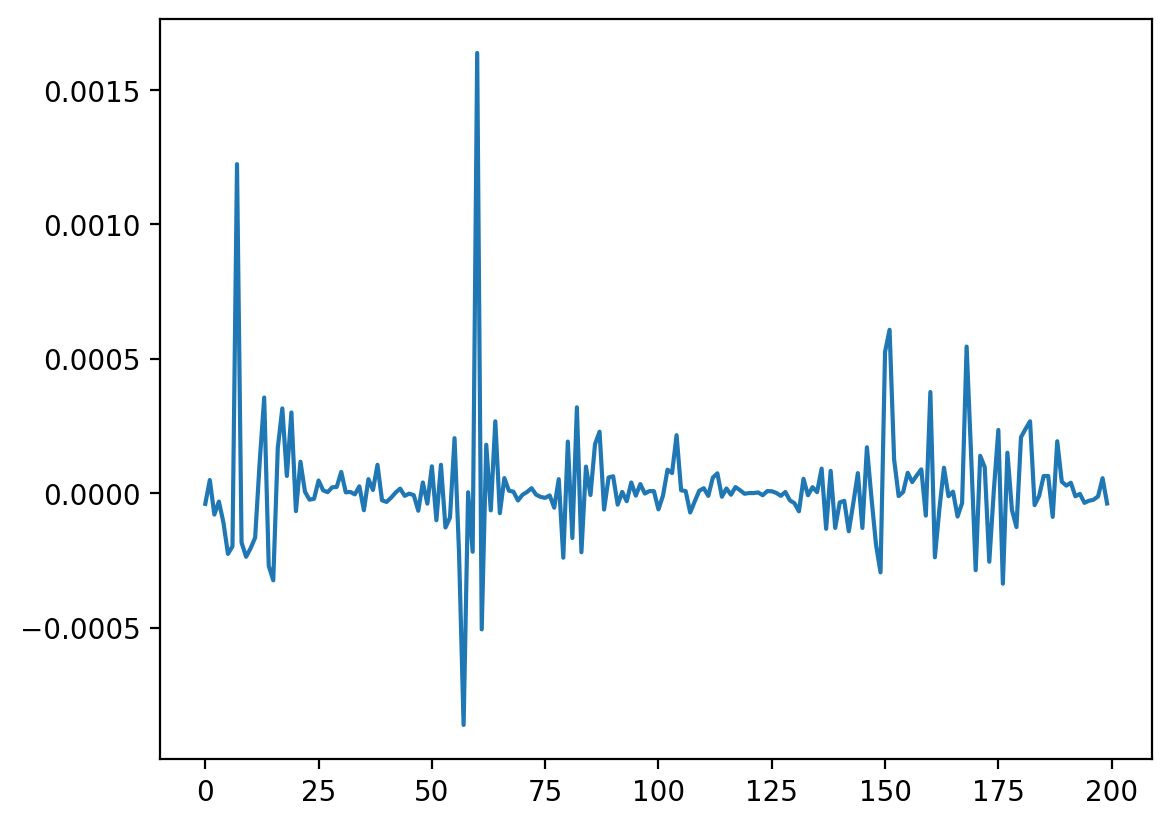

In [57]:
plt.plot(train_losses)
#plt.ylim(-0.04, 0)
print(train_losses[-1])

-3.611218105923306e-05


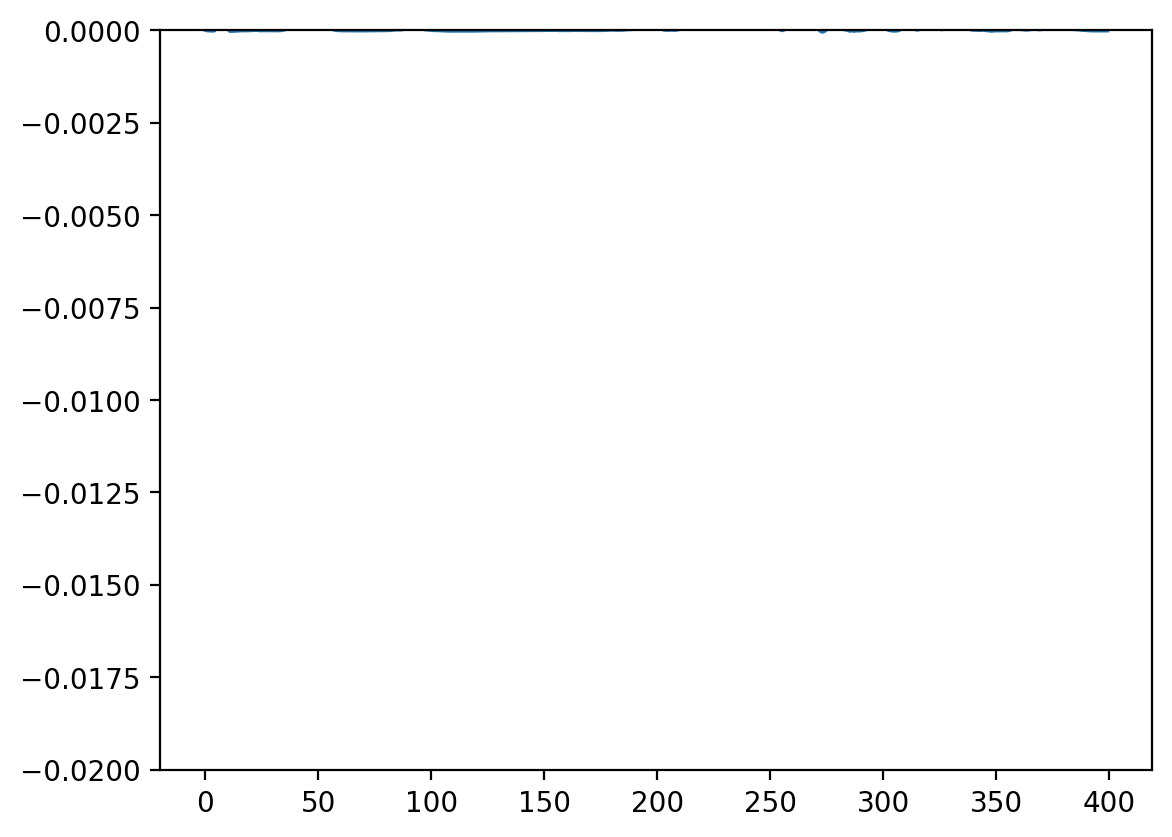

In [47]:
plt.plot(valid_losses)
plt.ylim(-0.02, 0)
print(best_valid_loss)

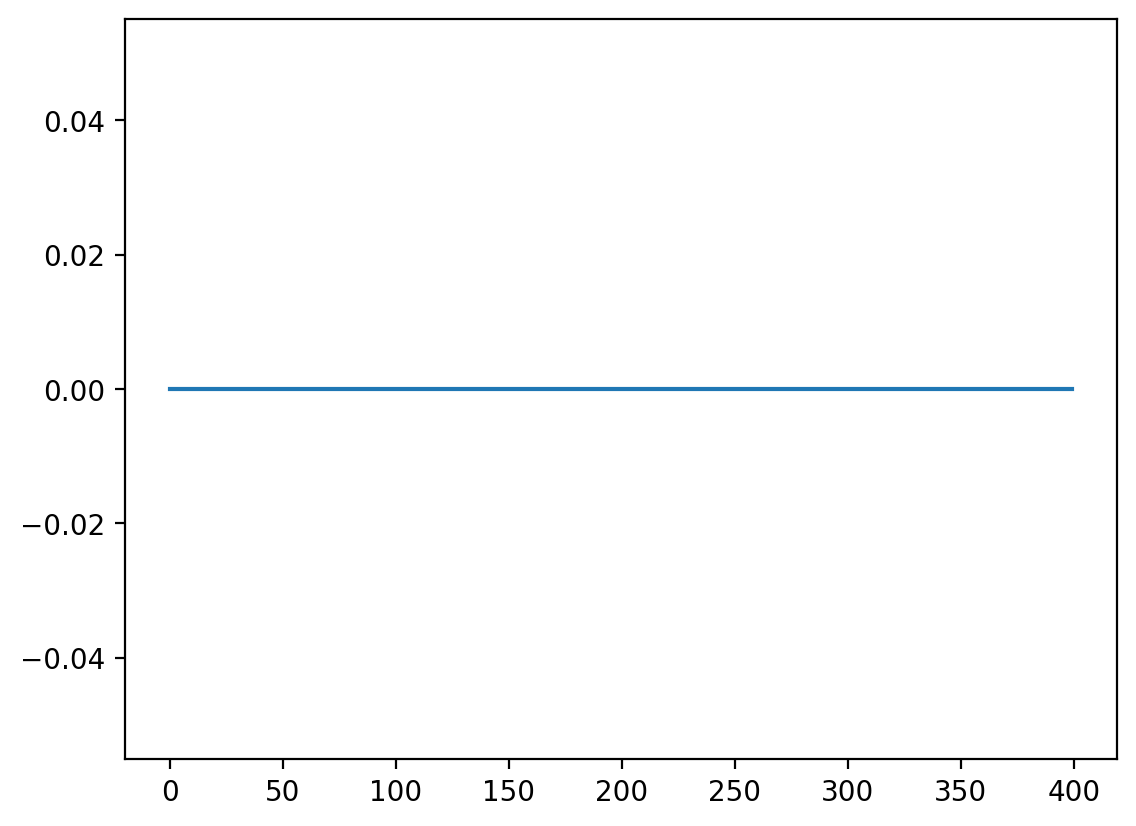

In [49]:
plt.plot(R_losses)

#### If you have no time for waiting until the training completed, you can load the parameter we prepared :)

In [ ]:
model.load_state_dict(torch.load("drive/MyDrive/CNEEP/results/2BS/T_1/L_10000/seed3/model_best.pth.tar",weights_only=False)['state_dict'])


RuntimeError: Error(s) in loading state_dict for CNEEP:
	Missing key(s) in state_dict: "fc2.weight", "fc2.bias", "lat1.0.weight", "lat1.0.bias", "lat2.0.weight", "lat2.0.bias", "r_layer2.conv1.weight", "r_layer2.conv1.bias", "r_layer2.conv2.weight", "r_layer2.conv2.bias", "r_layer1.conv.weight", "r_layer1.conv.bias". 
	Unexpected key(s) in state_dict: "out.0.weight", "out.0.bias". 
	size mismatch for fc1.weight: copying a param with shape torch.Size([1, 3200]) from checkpoint, the shape in current model is torch.Size([8, 12800]).
	size mismatch for fc1.bias: copying a param with shape torch.Size([1]) from checkpoint, the shape in current model is torch.Size([8]).

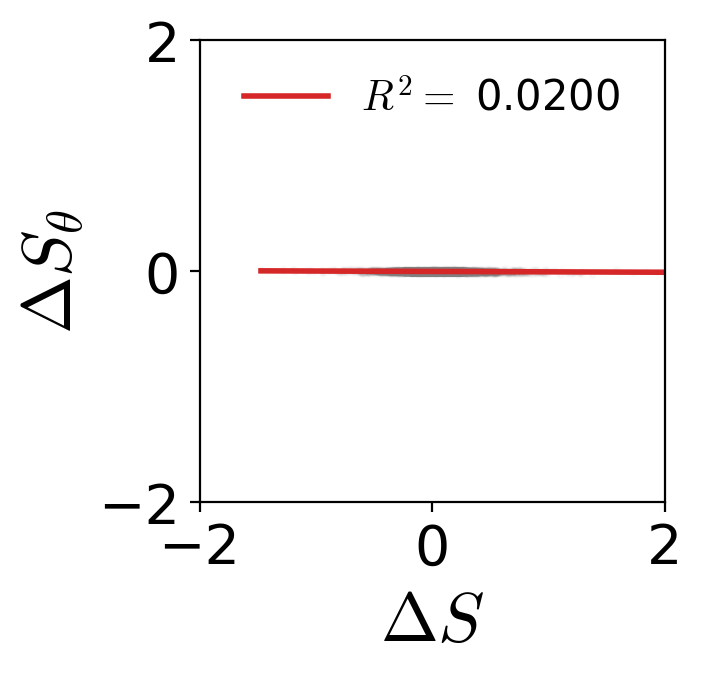

In [48]:
# A scatter plot after training the CNEEP

preds, _ = validate(opt, model, train_imgs_t, test_sampler, transform)
plot_scatter(preds.flatten(), ents.numpy().flatten(), trained=True)

## Dissipation map for the bead-spring model with $N=2$

Here, we introduce how we extract the dissipation map using weights of the last convolutional layer.

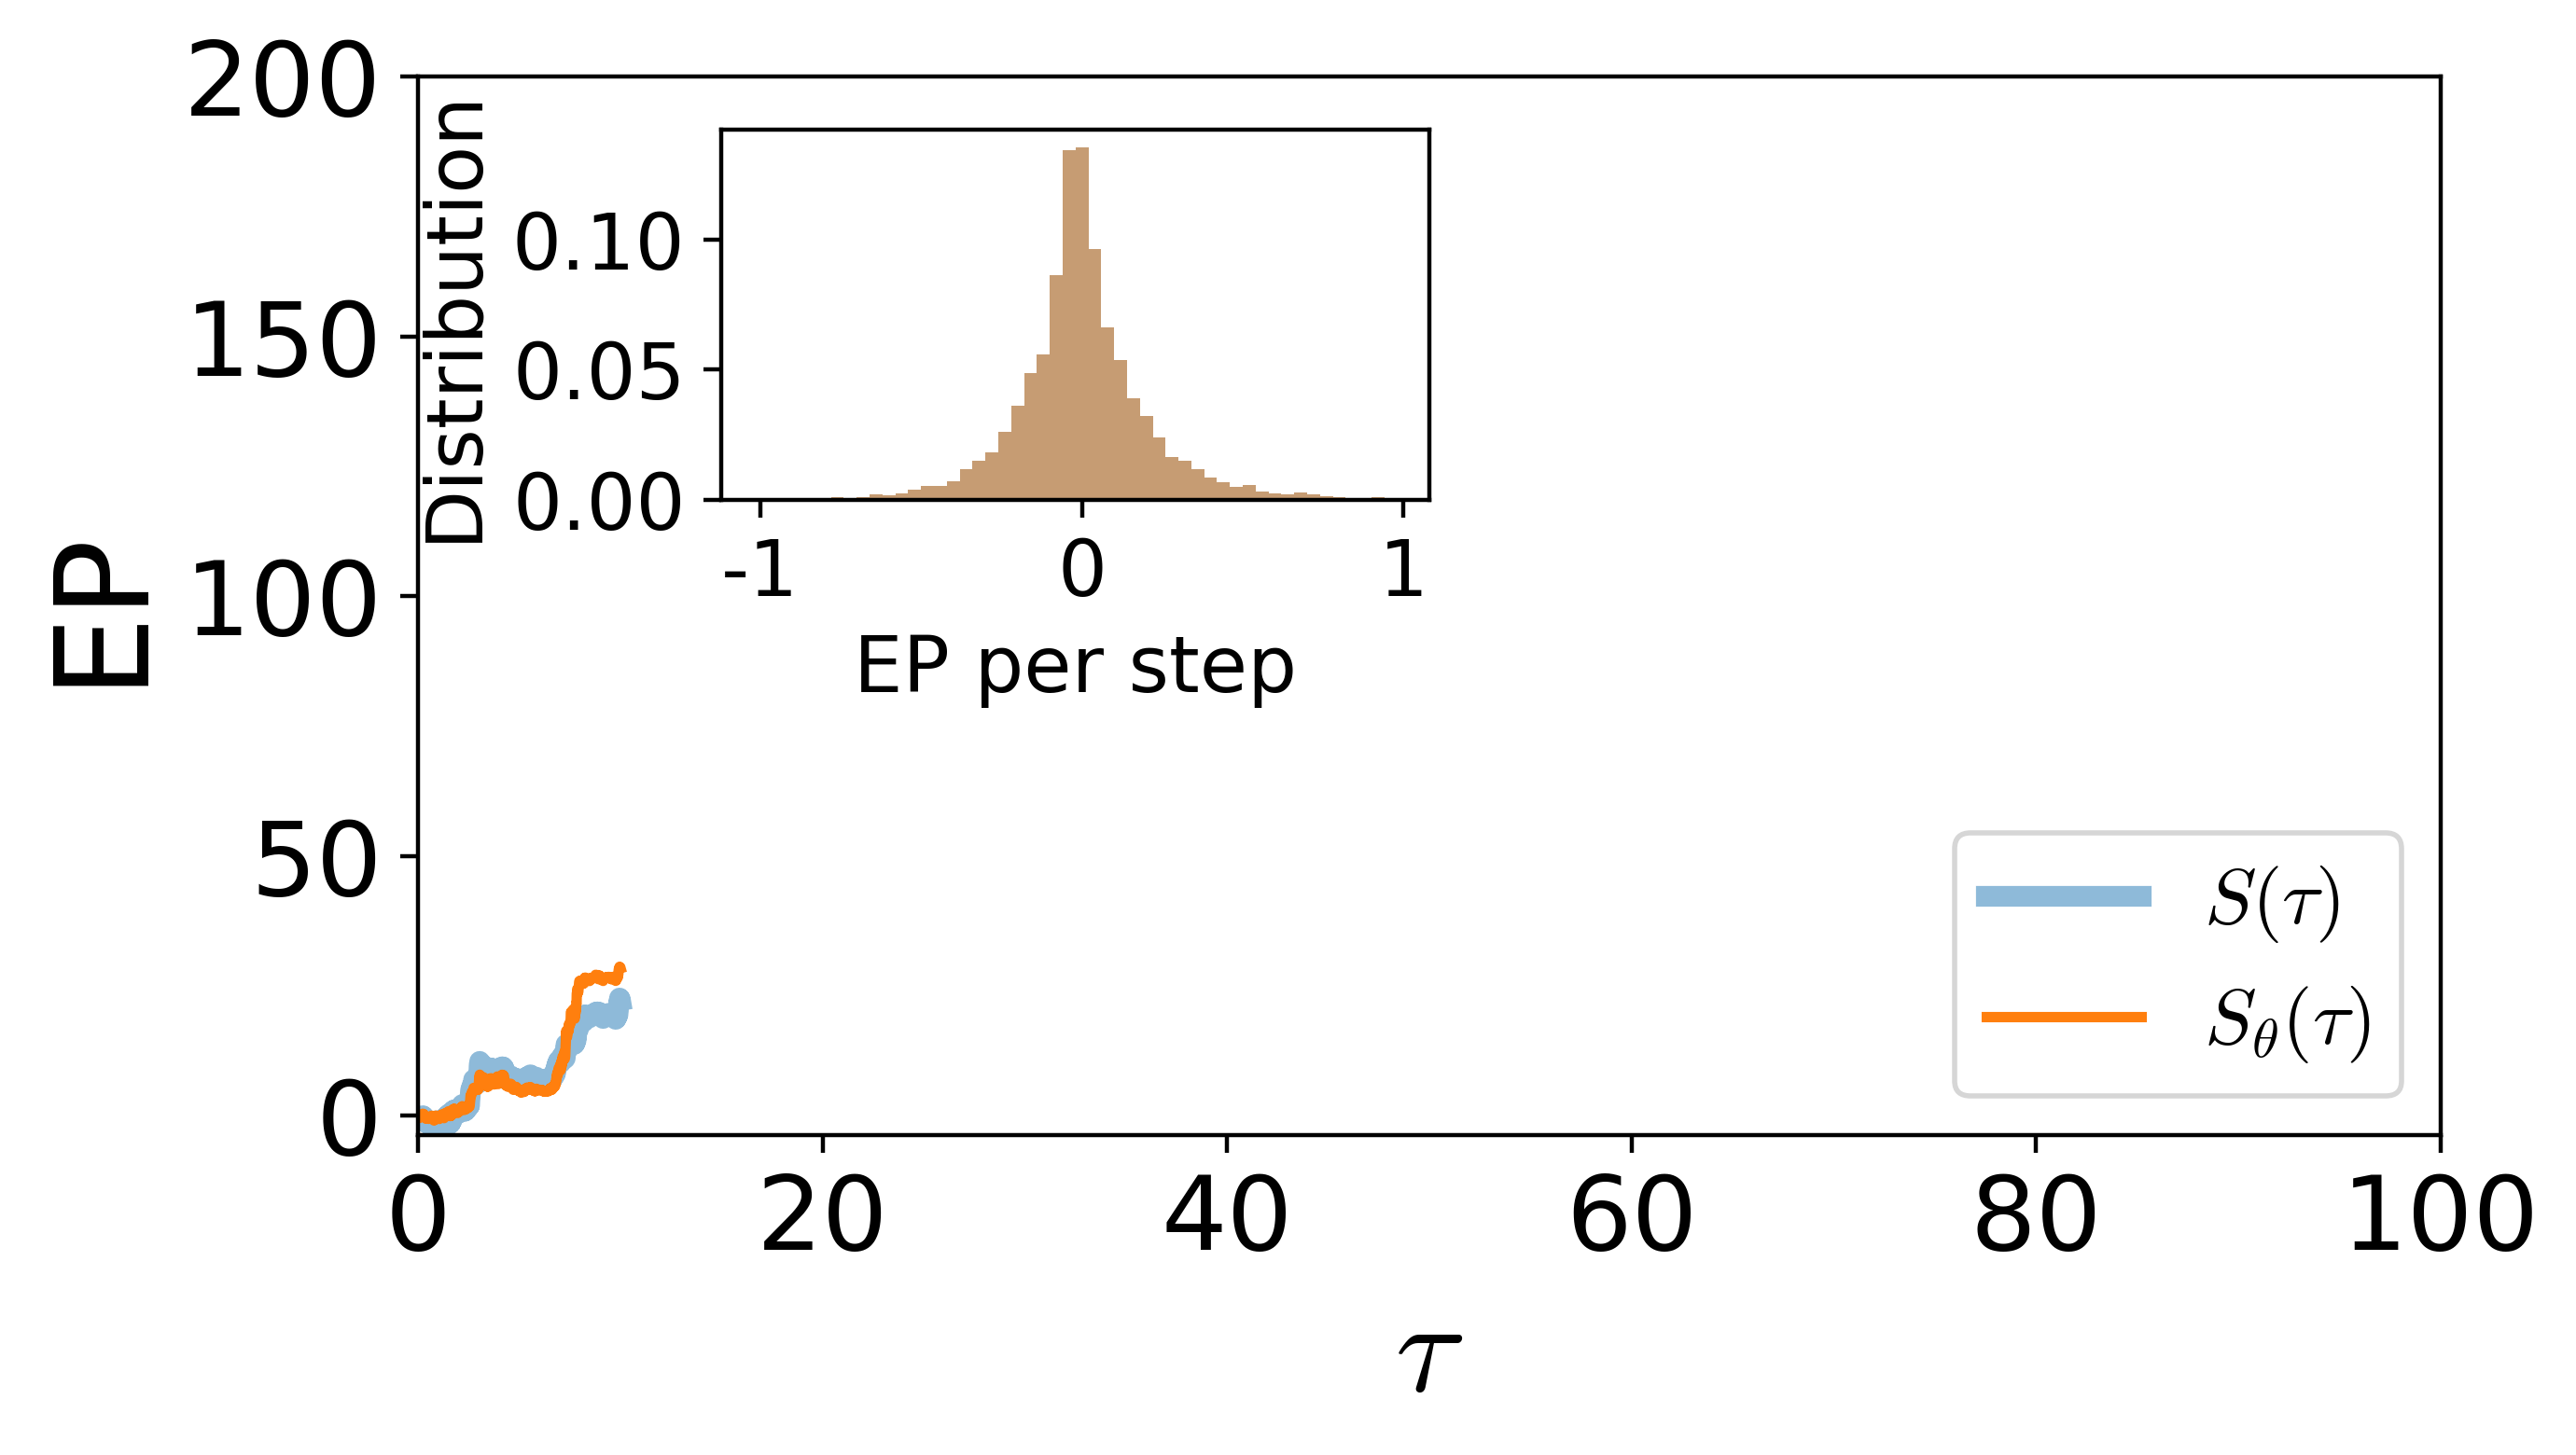

In [ ]:
# @title 기본 제목 텍스트
idx = 0 #np.random.randint(0, 1000)

ent = ents[idx]
pred = preds[idx]

cum_preds = np.cumsum(pred, axis=0)
cum_ents = np.cumsum(ent, axis=0)

taus = np.linspace(0, opt.L * opt.time_step, num=opt.L - 1)

plt.figure(figsize=(7, 4), dpi=200)
plt.plot(taus, np.cumsum(ent), lw=4, alpha=0.5,color='C0',
         label='$S(\\tau)$')
plt.plot(taus, np.cumsum(pred), lw=2, color='C1',
         label='$S_{\\theta}(\\tau)$')
# plt.plot([], ls = 'dotted', color='C0', lw=2,
#          label='$\sigma(\\tau)$')
# plt.plot([], lw=2, ls = '--', alpha=0.5, color='C1',
#          label='$\sigma_{\\theta}(\\tau)$')

plt.xlim(0)
plt.xlabel('$\\tau$', fontsize=25)
plt.ylabel(r'EP', fontsize=25)

plt.xticks([0, 20, 40, 60, 80, 100], fontsize=20)
plt.yticks([0, 50, 100, 150, 200], fontsize=20)

plt.legend(loc='lower right', frameon = True, fontsize=15)
ax = plt.gca()

axins = ax.inset_axes([0.15, 0.60, 0.35, 0.35])

values, bins = np.histogram(list(ents.flatten()), bins=50, range=(-1, 1))
values = values/np.sum(values)

axins.bar(bins[:-1], values, alpha=0.5, width=bins[:-1]-bins[1:])

values, bins = np.histogram(list(ents.flatten()), bins=50, range=(-1, 1))
values = values/np.sum(values)

axins.bar(bins[:-1], values, alpha=0.5, width=bins[:-1]-bins[1:])
axins.set_xlabel(r'EP per step', fontsize=15)
axins.set_ylabel(r'Distribution', fontsize=15)
axins.set_xticks([-1, 0, 1])
axins.set_yticks([0.00, 0.05, 0.10])
axins.set_xticklabels(labels=['-1', '0', '1'], fontsize=15)
axins.set_yticklabels(labels=['0.00', '0.05', '0.10'], fontsize=15)

plt.tight_layout()

PCA view

In [ ]:
# To save the attention map, we register the hook which append the attention map to 'feature_results' at the convolutional layer of our model.

feature_results = []
latent_results = []

hooks = []
def hook_feature(module, input, output):
    feature_results.append(output.cpu().detach().numpy())

def hook_latent(module, input, output):
    latent_results.append(output.cpu().detach().numpy())

hooks.append(model._modules.get('id').register_forward_hook(hook_feature))
hooks.append(model._modules.get('id2').register_forward_hook(hook_latent))
print(len(hooks))

2


In [ ]:
test_sampler = CartesianSeqSampler(1, opt.L, opt.seq_len, opt.video_batch_size, device=opt.device, train=False)

ent_productions, _ = validate(opt, model, train_imgs_t[:1], test_sampler, transform)

print(len(latent_results))

6


[ 1.1116266e-07 -3.5485625e-06  1.0207594e-05  2.4634601e-06
  8.3148478e-08  3.8039684e-06 -7.4562781e-06 -1.9216538e-06]
tensor([40.1759, 21.5677, 16.9578,  9.7403,  5.2958,  2.5408,  2.3900,  1.3317])
torch.Size([10, 1000, 2])


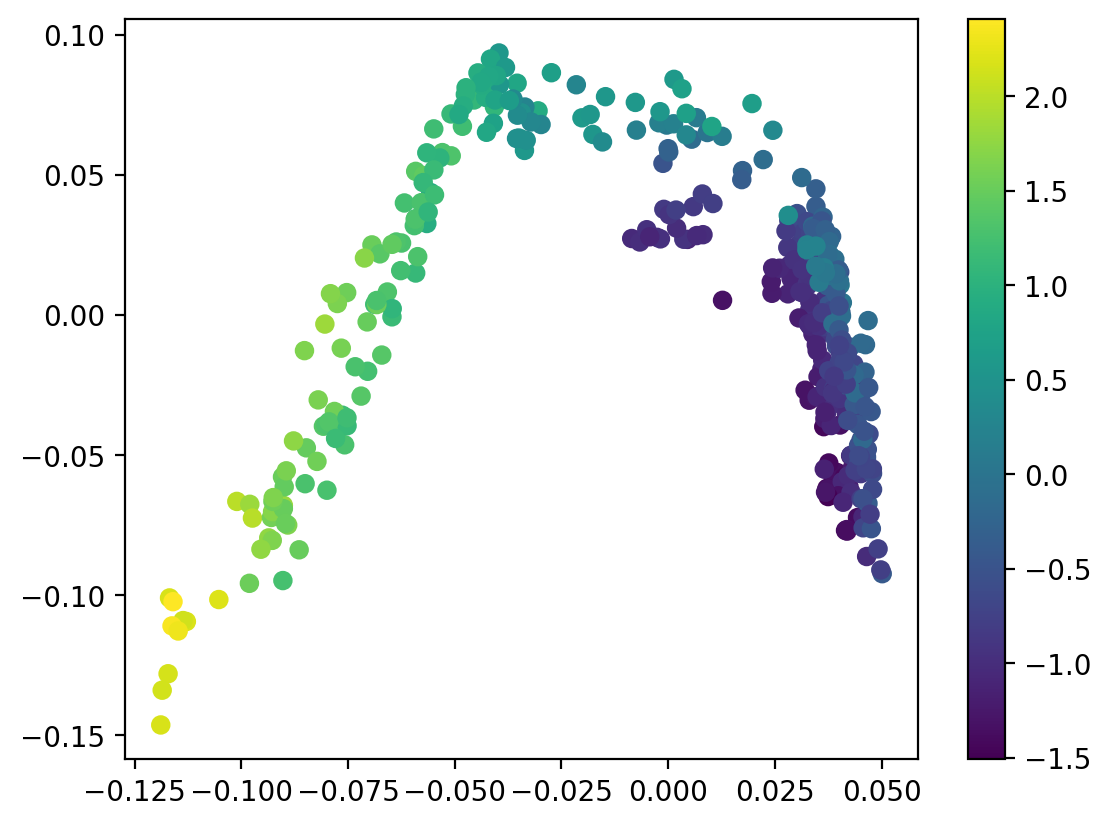

In [ ]:
latent_vectors = latent_results[0] - np.mean(latent_results[0], axis = 0)
latent_vectors = latent_vectors / np.std(latent_vectors, axis = 0)
print(np.mean(latent_vectors, axis = 0))

U, S, V = torch.pca_lowrank(torch.tensor(latent_vectors), q=8)

print(100 * S / sum(S))
x = U[:, 0]
y = U[:, 1]

print(trajs_t.shape)
x_1 = trajs_t[0, :400, 0]
x_2 = trajs_t[0, :400, 1]
x_12 = trajs_t[0, :400, 0] - trajs_t[0, :400, 1]
Dx_1 = trajs_t[0, :400, 0] - trajs_t[0, 1:401, 0]
Dx_12 = trajs_t[0, :400, 0] - trajs_t[0, :400, 1] - trajs_t[0, 1:401, 0] + trajs_t[0, 1:401, 1]
s = ents[0][:400]
curl = trajs_t[0, :400, 0] * (trajs_t[0, 1:401, 1] - trajs_t[0, 0:400, 1]) - trajs_t[0, :400, 1] * (trajs_t[0, 1:401, 0] - trajs_t[0, :400, 0])

color_data = x_2
colors= (color_data - color_data.mean()) / color_data.std()
plt.scatter(x, y, c=colors, cmap='viridis')
plt.colorbar()
plt.show()

In [ ]:
def corrcoef_torch(X, Y):
    X = X - X.mean(dim=0, keepdim=True)
    Y = Y - Y.mean(dim=0, keepdim=True)

    X = X / X.std(dim=0, unbiased=False, keepdim=True)
    Y = Y / Y.std(dim=0, unbiased=False, keepdim=True)

    return (X.T @ Y) / X.shape[0]

C = torch.stack([x_1, x_2, x_12, Dx_1, Dx_12, s, curl], dim=1)

<>:6: SyntaxWarning: invalid escape sequence '\D'
<>:6: SyntaxWarning: invalid escape sequence '\D'
<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\D'
<>:6: SyntaxWarning: invalid escape sequence '\D'
<>:6: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-1489858516.py:6: SyntaxWarning: invalid escape sequence '\D'
  custom_labels = ["$x_1$", "$x_2$", "$x_1 - x_2$", "$\Delta x_1$", "$\Delta (x_1 - x_2)$", "$s$", "$x_1 \dot{x}_2 - x_2 \dot{x}_1$"]
/tmp/ipython-input-1489858516.py:6: SyntaxWarning: invalid escape sequence '\D'
  custom_labels = ["$x_1$", "$x_2$", "$x_1 - x_2$", "$\Delta x_1$", "$\Delta (x_1 - x_2)$", "$s$", "$x_1 \dot{x}_2 - x_2 \dot{x}_1$"]
/tmp/ipython-input-1489858516.py:6: SyntaxWarning: invalid escape sequence '\d'
  custom_labels = ["$x_1$", "$x_2$", "$x_1 - x_2$", "$\Delta x_1$", "$\Delta (x_1 - x_2)$", "$s$", "$x_1 \dot{x}_2 - x_2 \dot{x}_1$"]


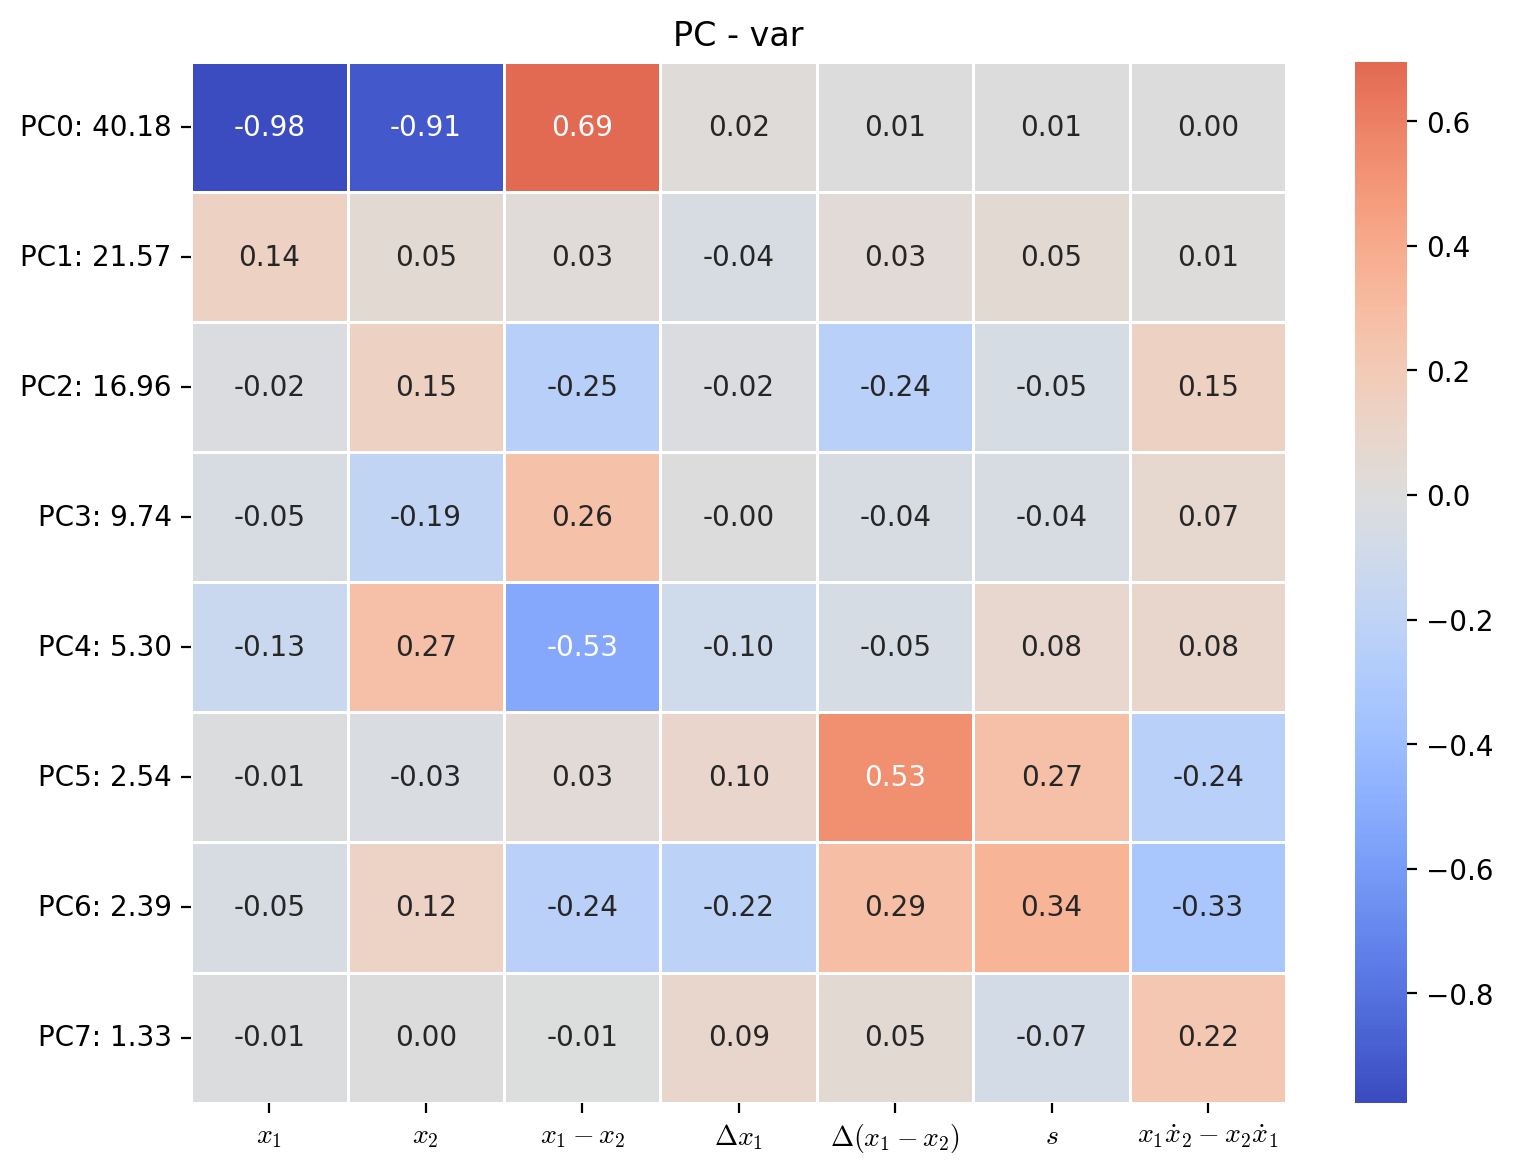

In [ ]:
corr_matrix = corrcoef_torch(U, C)

corr_np = corr_matrix.cpu().numpy()

pca_labels = [f'PC{i}: {100 * S[i] / sum(S) :.2f}' for i in range(U.shape[1])]
custom_labels = ["$x_1$", "$x_2$", "$x_1 - x_2$", "$\Delta x_1$", "$\Delta (x_1 - x_2)$", "$s$", "$x_1 \dot{x}_2 - x_2 \dot{x}_1$"]

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_np,
    xticklabels=custom_labels,
    yticklabels=pca_labels,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5
)
plt.title("PC - var")
plt.tight_layout()
plt.show()

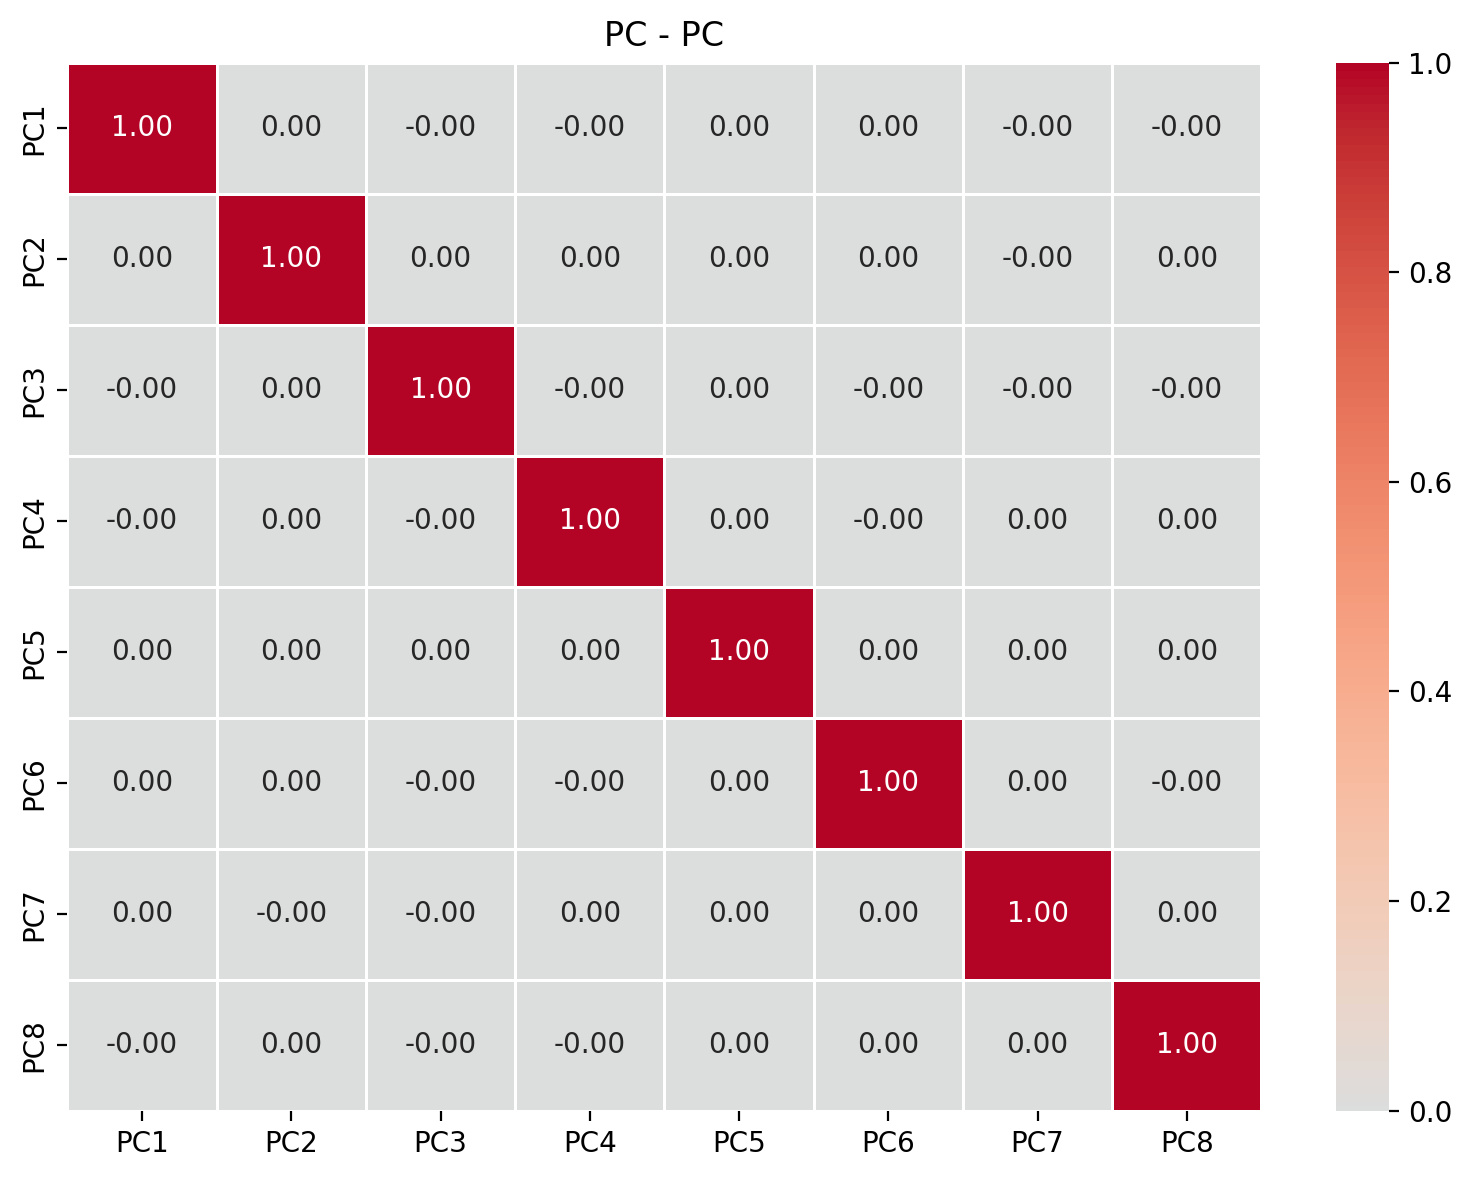

In [ ]:
corr_matrix = corrcoef_torch(U, U)

corr_np = corr_matrix.cpu().numpy()

pca_labels = [f'PC{i+1}' for i in range(U.shape[1])]
custom_labels = [f'PC{i+1}' for i in range(U.shape[1])]

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_np,
    xticklabels=custom_labels,
    yticklabels=pca_labels,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5
)
plt.title("PC - PC")
plt.tight_layout()
plt.show()

<>:5: SyntaxWarning: invalid escape sequence '\D'
<>:5: SyntaxWarning: invalid escape sequence '\D'
<>:5: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\D'
<>:6: SyntaxWarning: invalid escape sequence '\D'
<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:5: SyntaxWarning: invalid escape sequence '\D'
<>:5: SyntaxWarning: invalid escape sequence '\D'
<>:5: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\D'
<>:6: SyntaxWarning: invalid escape sequence '\D'
<>:6: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-2135720743.py:5: SyntaxWarning: invalid escape sequence '\D'
  pca_labels = ["$x_1$", "$x_2$", "$x_1 - x_2$", "$\Delta x_1$", "$\Delta (x_1 - x_2)$", "$s$", "$x_1 \dot{x}_2 - x_2 \dot{x}_1$"]
/tmp/ipython-input-2135720743.py:5: SyntaxWarning: invalid escape sequence '\D'
  pca_labels = ["$x_1$", "$x_2$", "$x_1 - x_2$", "$\Delta x_1$", "$\Delta (x_1 - x_2)$", "$s$", "$x_1 \dot{x}

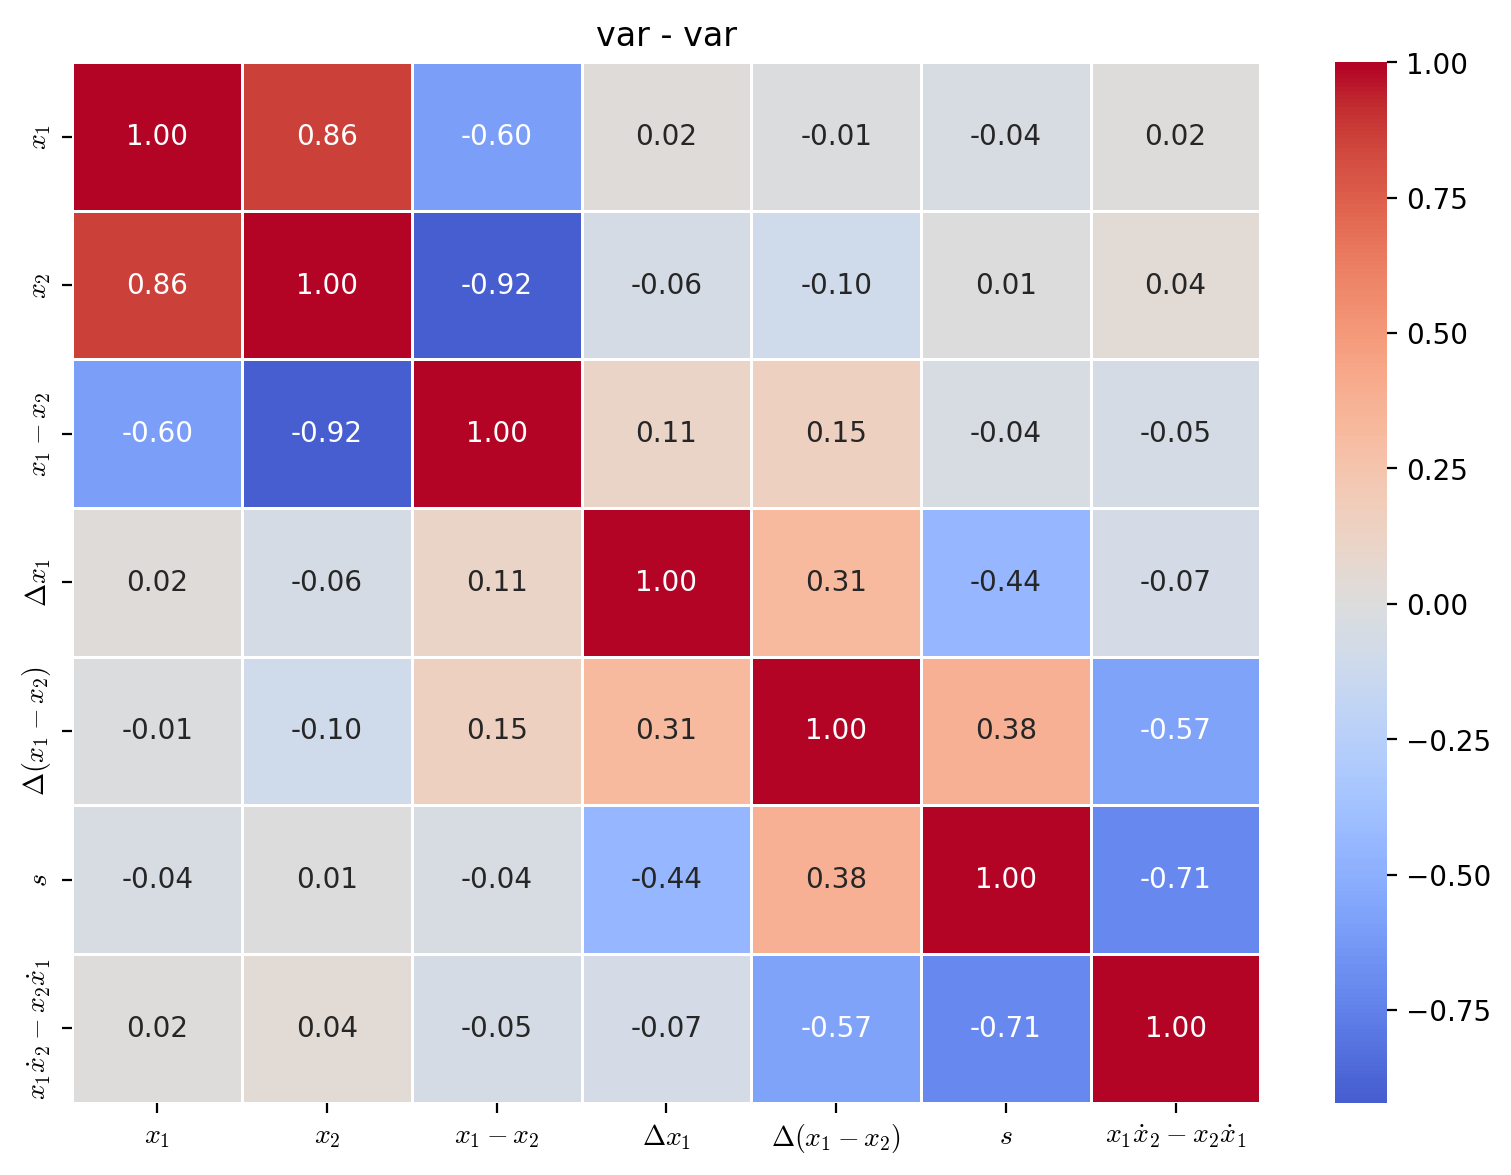

In [ ]:
corr_matrix = corrcoef_torch(C, C)

corr_np = corr_matrix.cpu().numpy()

pca_labels = ["$x_1$", "$x_2$", "$x_1 - x_2$", "$\Delta x_1$", "$\Delta (x_1 - x_2)$", "$s$", "$x_1 \dot{x}_2 - x_2 \dot{x}_1$"]
custom_labels = ["$x_1$", "$x_2$", "$x_1 - x_2$", "$\Delta x_1$", "$\Delta (x_1 - x_2)$", "$s$", "$x_1 \dot{x}_2 - x_2 \dot{x}_1$"]

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_np,
    xticklabels=custom_labels,
    yticklabels=pca_labels,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5
)
plt.title("var - var")
plt.tight_layout()
plt.show()

### First, we check the dissipation map $\mathcal{H}(x, y)$ along a movie, representing where and how much EP occurs at each time step.

In [ ]:
train_sampler = CartesianSeqSampler(1, opt.L, opt.seq_len, opt.video_batch_size, device=opt.device)
test_sampler = CartesianSeqSampler(1, opt.L, opt.seq_len, opt.video_batch_size, device=opt.device, train=False)

params = list(model.parameters())
weight =  1/800 * 20 #np.squeeze(params[-2].cpu().data.numpy())    # the weight of the last layer, $w_c$ in the paper.

feature_results = []

preds = validate(opt, model, train_imgs_t[:1], test_sampler, transform)
feature_shape = feature_results[0][0][0].shape     # the shape of the attention map $ \mathcal{H}(x, y)$

map_f = weight * feature_results[0].reshape((opt.video_batch_size, -1))   # Eq.(4) in the paper for a forward transition.
map_f = map_f.reshape(opt.video_batch_size, 1, feature_shape[0], feature_shape[1]).sum(axis=1)

map_r = weight * feature_results[1].reshape((opt.video_batch_size, -1))   # Eq.(4) in the paper for a backward transition.
map_r = map_r.reshape(opt.video_batch_size, 1, feature_shape[0], feature_shape[1]).sum(axis=1)

final_map = map_f-map_r

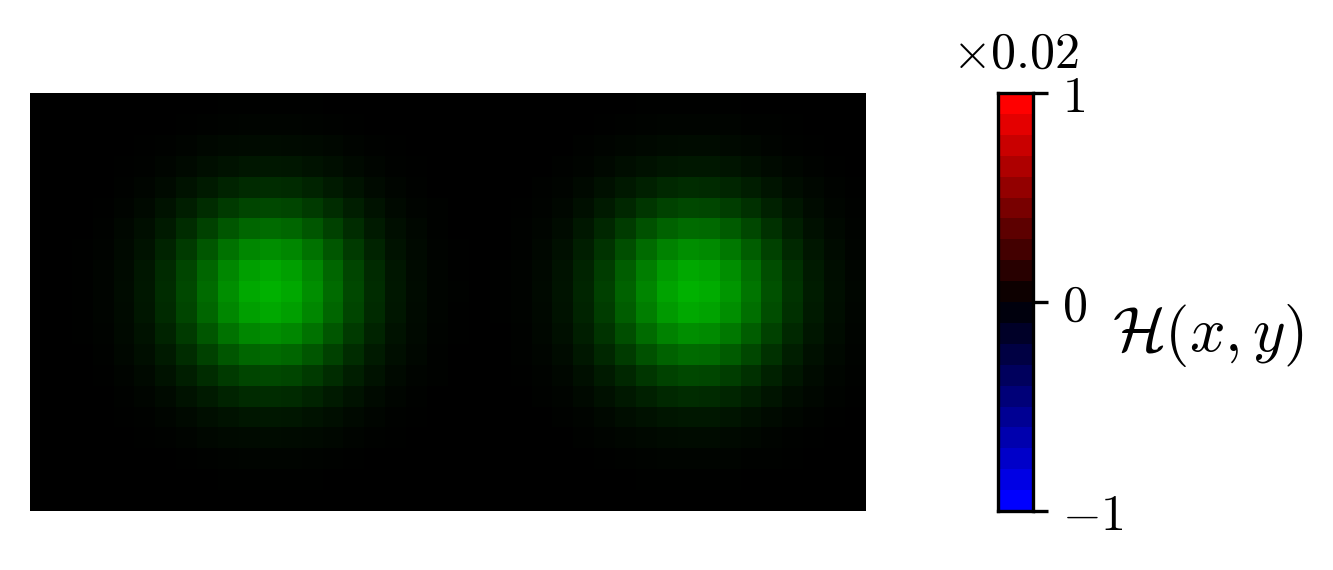

In [ ]:
import cv2
from matplotlib import gridspec

frame_length = 100 * 4

fig1 = plt.figure(figsize=(5, 2), dpi=150)
gs = gridspec.GridSpec(nrows=1, ncols=2, height_ratios=[1], width_ratios=[25, 1])

# these codes are for a colorbar
ax2 = plt.subplot(gs[1])
cbar = np.linspace(0, 1, 20).reshape((20, 1))
ax2.imshow(cbar, cmap= mpl.colors.LinearSegmentedColormap.from_list('my_colormap', ['blue', 'black','red'], 20),
                 vmin=0, vmax=1, extent=[0, 0.5, 0, 6], origin ='lower')
plt.tick_params(axis='x', bottom=False, top=False, labelbottom=False)
ax2.yaxis.tick_right()
ax2.set_yticks([0, 3, 6])
ax2.set_yticklabels([r'$-1$', r'$0$', r'$1$'], fontsize=12)
plt.title(r'$\times 0.02$')
ax2.yaxis.set_label_position("right")
ax2.set_ylabel(r'$\mathcal{H}(x, y)$', rotation='horizontal', fontsize=15, labelpad=20)


# these codes are for a dissipation map along a movie.
ax1 = plt.subplot(gs[0])
pos_epmap = np.zeros(final_map.shape)
pos_epmap[final_map > 0] = final_map[final_map > 0]

neg_epmap = np.zeros(final_map.shape)
neg_epmap[final_map < 0] = final_map[final_map < 0]

dst1 = np.zeros((frame_length, opt.input_shape[0], opt.input_shape[1], 3))
dst2 = np.zeros((frame_length, opt.input_shape[0], opt.input_shape[1], 3))

dst1[:, :, :, 1] = 0.7 * train_imgs[0][:frame_length].astype(np.float64)/255   # green
dst2[:, :, :, 0] = pos_epmap[:frame_length] * 100      # red
dst2[:, :, :, 2] = -neg_epmap[:frame_length] * 100     # blue

dst = dst1[0] + cv2.resize(dst2[0], (opt.input_shape[1], opt.input_shape[0]))/16


img1 = ax1.imshow(dst, extent=[0, 2, 0, 1], origin ='lower')
plt.axis('off')
plt.tight_layout()

def animate(i):
    img1.set_data(dst1[i] + cv2.resize(dst2[i], (opt.input_shape[1], opt.input_shape[0]))/16)

    return (img1,)

anim = animation.FuncAnimation(fig1, animate, frames=frame_length, interval=50, blit=True)
HTML(anim.to_html5_video())


### Second, we check the averaged dissipation map $\langle \dot{\mathcal{H}} (x, y) \rangle$ over movies.

In [ ]:
train_sampler = CartesianSeqSampler(1, opt.L, opt.seq_len, opt.video_batch_size, device=opt.device)
test_sampler = CartesianSeqSampler(1, opt.L, opt.seq_len, opt.video_batch_size, device=opt.device, train=False)

params = list(model.parameters())
weight = 1/800  # np.squeeze(params[-2].cpu().data.numpy())       # the weight of the last layer, $w_c$ in the paper.

# Average over M movies
for j in tqdm(range(opt.M)):
    feature_results = []

    preds = validate(opt, model, train_imgs_t[j:j+1], test_sampler, transform)
    feature_shape = feature_results[0][0][0].shape

    for i in range(1+(opt.L-1)//opt.video_batch_size):
        steps = opt.video_batch_size if i < (opt.L-1)//opt.video_batch_size else (opt.L-1)%opt.video_batch_size

        map_f = weight * feature_results[2*i].reshape((steps, -1))
        map_f = map_f.reshape(steps, 1, feature_shape[0], feature_shape[1]).sum(axis=1)

        map_r = weight * feature_results[2*i+1].reshape((steps, -1))
        map_r = map_r.reshape(steps, 1, feature_shape[0], feature_shape[1]).sum(axis=1)

        if i == 0:
            final_map = map_f-map_r

        else:
            final_map = np.concatenate((final_map, map_f-map_r), axis=0)

    if j == 0:
        dissp_map = np.mean(final_map, axis=0)

    else:
        dissp_map += np.mean(final_map, axis=0)


  0%|          | 0/10 [00:00<?, ?it/s]

Sum of the averaged dissipation map:  0.20492136


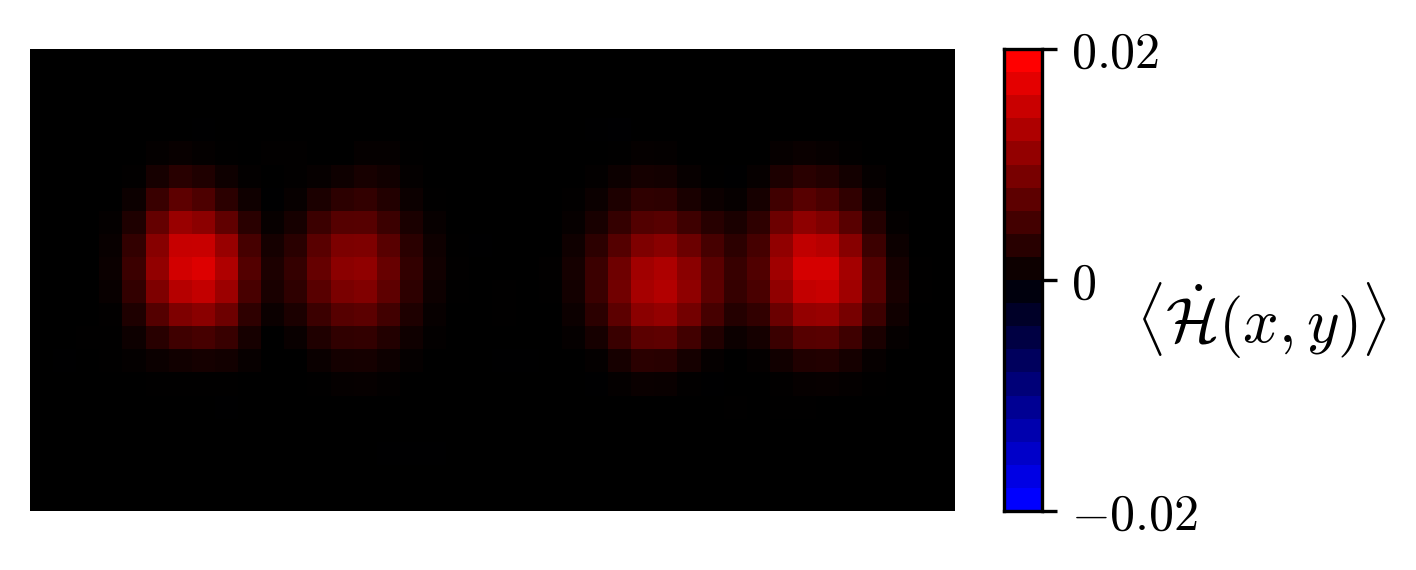

In [ ]:
idx = 0

fig1 = plt.figure(figsize=(5, 2), dpi=150)
gs = gridspec.GridSpec(nrows=1, ncols=2, height_ratios=[1], width_ratios=[25, 1])

# these codes are for a colorbar
ax2 = plt.subplot(gs[1])
cbar = np.linspace(0, 1, 20).reshape((20, 1))
ax2.imshow(cbar, cmap= mpl.colors.LinearSegmentedColormap.from_list('my_colormap', ['blue', 'black','red'], 20),
                 vmin=0, vmax=1, extent=[0, 0.5, 0, 6], origin ='lower')
plt.tick_params(axis='x', bottom=False, top=False, labelbottom=False)
ax2.yaxis.tick_right()
ax2.set_yticks([0, 3, 6])
ax2.set_yticklabels([r'$-0.02$', r'$0$', r'$0.02$'], fontsize=12)
ax2.yaxis.set_label_position("right")
ax2.set_ylabel(r'$\langle \dot{\mathcal{H}}(x, y) \rangle$', rotation='horizontal', fontsize=15, labelpad=15)

# these codes are for a dissipation map along a movie.
ax1 = plt.subplot(gs[0])
dst2 = np.zeros((opt.input_shape[0], opt.input_shape[1], 3))

f = 100
dst2[:, :, 0] = dissp_map * 50 * f     # red
dst2[:, :, 2] = -dissp_map * 50 * f   # blue

dst = cv2.resize(dst2, (opt.input_shape[1], opt.input_shape[0]))/(16)

img1 = ax1.imshow(dst, extent=[0, 2, 0, 1], origin ='lower')
plt.axis('off')
plt.tight_layout()

print(r"Sum of the averaged dissipation map: ", np.sum(dissp_map))